In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itk
from itkwidgets import view
import SimpleITK as sitk
from skimage import img_as_ubyte
from skimage.io import imread, imsave, imshow
import pandas as pd

In [16]:
input_skeleton = r"D:\Cecile\Results\Stade 3\P15 10 03 A CARIE STD 3 CONFOCAL\Skeleton_Otsu_tubeness4 of Edge.tif"
skeleton_itk = itk.imread(input_skeleton)
#print(skeleton_itk)
input_dm = r"D:\Cecile\Results\Stade2_ancienmicro\P185AVECAD_carie\EDT_Resampling2.tif"
dm_itk = itk.imread(input_dm)
#print(dm_itk)

In [17]:
size = itk.size(skeleton_itk)
width = size[0]
height = size[1]
slices = size[2]
print(width, height, slices)

498 522 237


In [5]:
array_dm = (itk.array_view_from_image(dm_itk))/(2.8963)
view(array_dm)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

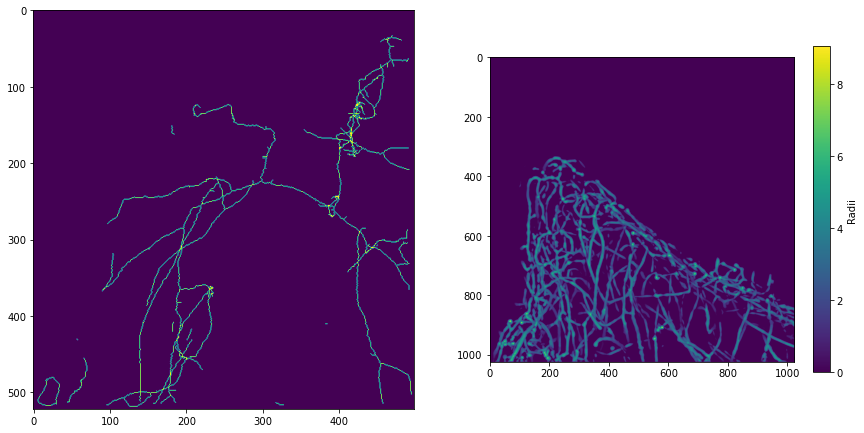

In [21]:
proj_skeleton = itk.maximum_projection_image_filter(skeleton_itk)
#print(proj_skeleton)
np_view_skeleton = itk.array_view_from_image(proj_skeleton)
# print(np_view_skeleton)
proj_dm = itk.maximum_projection_image_filter(dm_itk)
np_view_dm = (itk.array_view_from_image(proj_dm))*0.690534
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np_view_skeleton[0])
plt.subplot(1,2,2)
plt.imshow(np_view_dm[0])
plt.colorbar(shrink=0.4, label="Radii", orientation="vertical")
plt.clim(0, 9.05)
plt.show()

In [11]:
array_dm = itk.array_view_from_image(dm_itk)
view(array_dm)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [19]:
array_dm = itk.array_view_from_image(dm_itk)*0.690534
print(array_dm.max())
diam_pix = np.zeros((slices, height, width))
array_skeleton = itk.array_view_from_image(skeleton_itk)
print(array_skeleton.shape)
for y in range(height):
    for x in range(width):
        for z in range(slices):
            skeleton = array_skeleton[z,y,x]
            if skeleton != 0:
                diam_pix[z,y,x] = array_dm[z,y,x]                              

8.541299
(237, 522, 498)


IndexError: index 233 is out of bounds for axis 0 with size 59

In [54]:
#Ajuster la valeur du rayon au ratio dimensions voxels en microm
dim_reel = 1

diam = diam_pix * dim_reel

In [28]:
itk.imwrite(vesselness_filter,  r"D:\Cecile\Caries\Stade3\P15 10 03 A CARIE STD 3 CONFOCAL\Vess_15.tif")

NameError: name 'vesselness_filter' is not defined

In [55]:
print(array_dm.max(),array_dm.min())
print(diam.max(),diam.min())
print(diam.shape)

9.539392 0.0
9.05538558959961 0.0
(75, 1024, 1024)


In [30]:
diam_255 = diam*(255/array_dm.max())
print(diam.shape)
view(diam)

(59, 1024, 1024)


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [9]:
diam_itk = itk.image_from_array(diam)
itk.imwrite(diam,  r"D:\Cecile\Results\Dent saine\P09A_VECAD_dent saine_corne\diam.tif")

AttributeError: 'numpy.ndarray' object has no attribute 'UpdateOutputInformation'

In [56]:
diam_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if diam[z,y,x] != 0:
                diam_list.append(diam[z,y,x])
diam_array = np.array(diam_list)
print(diam_array.shape)

df = pd.DataFrame(diam_array)
df.to_excel(excel_writer = r"D:\Cecile\Results\Stade2_ancienmicro\P18-5A-VECAD-corne saine\diam_anal.xlsx")

(24623,)


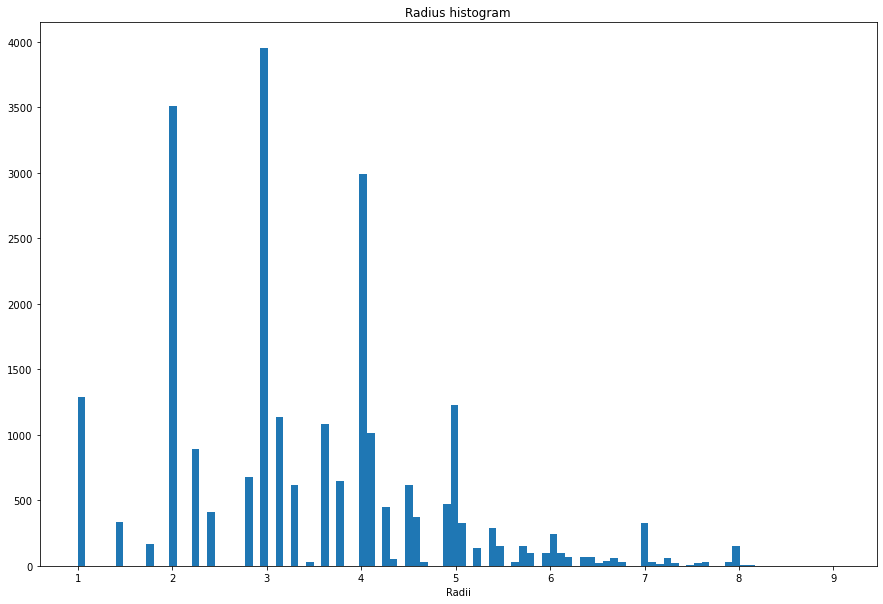

In [57]:
#Histogramme des diamètres
plt.figure(figsize=(15,10))
plt.hist(diam_list, 100)
plt.title('Radius histogram')
plt.xlabel("Radii")
plt.show()

In [10]:
diam_itk = itk.image_from_array(diam)
#diam_255_itk = itk.image_from_array(diam_255)
proj_diam = itk.maximum_projection_image_filter(diam_itk)

np_view_diam = itk.array_view_from_image(proj_diam)
#np_view_diam_255 = itk.array_view_from_image(diam_255_itk)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np_view_diam)
plt.subplot(1,2,2)
plt.imshow(np_view_skeleton)
plt.show()

RuntimeError: C:\P\IPP\ITK-source\ITK\Modules\Core\Common\include\itkImportImageContainer.hxx:192:
Failed to allocate memory for image.

In [9]:
count_diam = 0
for y in range(height):
    for x in range(width):
            diam_intensity = diam[y,x]
            if diam_intensity != 0:
                count_diam = count_diam +1
print(count_diam)

35157


In [58]:
diam_only = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if diam[z,y,x] != 0:
                diam_only.append([z,y,x])

#print(diam_only)
#print(diam[14,3,11])
print(len(diam_only))
# print(diam_only[2][0])

24623


In [19]:
#Estimer la localisation de la carie en un point

import math

carie_x = 894
carie_y = 130
carie_z = 213 

dist=[None]*len(diam_only)
diameters=[None]*len(diam_only)

for k in range(len(diam_only)):
    dist[k]= math.sqrt((diam_only[k][0] - carie_z)**2+(diam_only[k][1] - carie_y)**2+(diam_only[k][2] - carie_x)**2)
    diameters[k] = diam[diam_only[k][0], diam_only[k][1], diam_only[k][2]]
#print(dist, diameters)


In [20]:
array_plot_total = []
#print(array_plot)
# for k in range(len(dist_cap)):
for k in range(len(dist)):
    array_plot_total.append([dist[k],diameters[k]])
#     array_plot[k][0] = dist_cap[k]
#     print(k, dist_cap[k], array_plot[k][0])
#     array_plot[k][1] = diameters_cap[k]
#     print(k, diameters_cap[k], array_plot[k][1])
print(array_plot_total, len(array_plot_total), max(array_plot_total), min(array_plot_total)) 
array_plot_total.sort()
print("Sorted:",array_plot_total)

[[252.82998239923998, 4.0], [252.7568001063473, 4.0], [252.68755410585618, 4.0], [253.1817528970048, 4.0], [253.6828728944861, 4.0], [253.62570847609277, 4.0], [254.13775791881065, 4.0], [32.87856444554719, 10.29563045501709], [31.575306807693888, 9.848857879638672], [31.016124838541646, 10.29563045501709], [29.732137494637012, 9.848857879638672], [28.460498941515414, 9.273618698120117], [27.94637722496424, 9.539392471313477], [39.102429592034305, 11.045360565185547], [37.77565353504821, 10.862780570983887], [37.17526059088221, 11.0], [35.86084215408221, 10.770329475402832], [34.55430508634199, 10.440306663513184], [27.16615541441225, 8.9442720413208], [25.96150997149434, 8.485280990600586], [24.779023386727733, 7.874007701873779], [23.62202362203543, 7.071067810058594], [42.09513035969837, 11.0], [40.76763422127902, 11.045360565185547], [23.790754506740637, 7.280109882354736], [45.02221673796171, 11.045360565185547], [44.384682042344295, 11.224971771240234], [43.76071297408213, 10.862

In [21]:
dist_sorted = []
diam_sorted = []

for k in range(len(array_plot_total)):
    dist_sorted.append(array_plot_total[k][0])
    diam_sorted.append(array_plot_total[k][1])
#print("dist", dist_sorted, "diam", diam_sorted)

In [22]:
print(len(dist), len(diameters))
print(max(diameters))

32184 32184
19.748416900634766


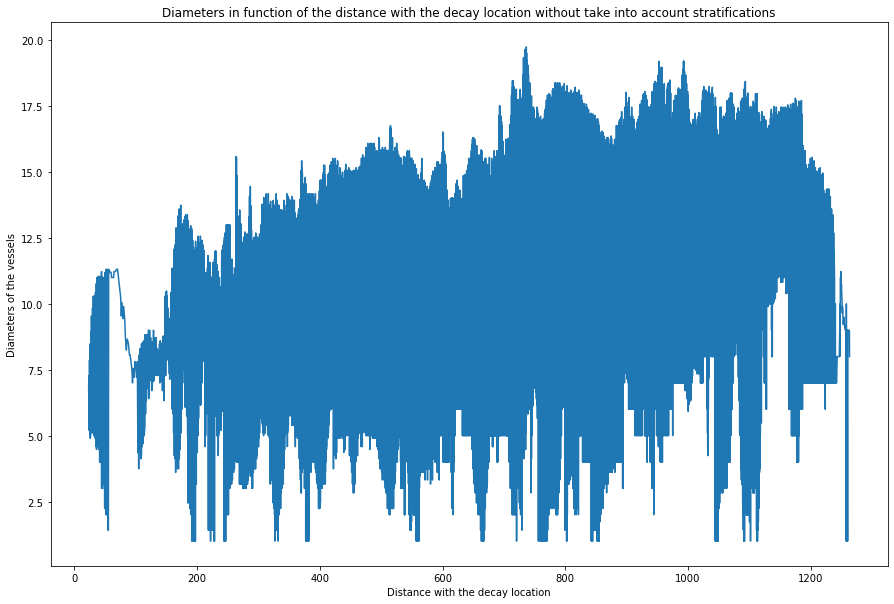

In [23]:
plt.figure(figsize=(15,10))
plt.plot(dist_sorted, diam_sorted)
plt.title("Diameters in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Diameters of the vessels")
plt.show()

In [35]:
#Histogramme des diamètres
plt.figure(figsize=(15,10))
plt.hist(diameters, 100)
plt.title('Diameter histogram')
plt.xlabel("Diameters")
plt.show()

NameError: name 'diameters' is not defined

<Figure size 1080x720 with 0 Axes>

In [59]:
#Définir les trois types de vaisseaux à partir de leur diamètre

cap = np.zeros((slices, height, width)) 
inter = np.zeros((slices, height, width)) 
big = np.zeros((slices, height, width)) 

for k in range(len(diam_only)):
    intensity = diam[diam_only[k][0], diam_only[k][1], diam_only[k][2]]
    if intensity < 6.9:
        cap[diam_only[k][0], diam_only[k][1], diam_only[k][2]] = intensity
    elif intensity <25 and intensity >= 0:
        inter[diam_only[k][0], diam_only[k][1], diam_only[k][2]] = intensity
    else :
        big[diam_only[k][0], diam_only[k][1], diam_only[k][2]] = intensity
print("cap: ",cap.max(), cap.min(), "inter: ", inter.max(), inter.min(), "big: ", big.max(), big.min())
        
    

MemoryError: Unable to allocate 600. MiB for an array with shape (75, 1024, 1024) and data type float64

In [60]:
cap_list_direct = []
inter_list_direct = []

for k in range(len(diam_only)):
    intensity = diam[diam_only[k][0], diam_only[k][1], diam_only[k][2]]
    if intensity < 6.9:
        cap_list_direct.append(intensity)
    elif intensity <25 and intensity >= 0:
        inter_list_direct.append(intensity)
    else :
        big[diam_only[k][0], diam_only[k][1], diam_only[k][2]] = intensity
print("cap: ",max(cap_list_direct), min(cap_list_direct), "inter: ", max(inter_list_direct), min(inter_list_direct))
print(len(cap_list_direct), len(inter_list_direct))

cap:  6.78233003616333 1.0 inter:  9.05538558959961 7.0
23918 705


In [38]:
cap_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if cap[z,y,x] != 0:
                cap_list.append(cap[z,y,x])
            
inter_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if inter[z,y,x] != 0:
                inter_list.append(inter[z,y,x])
                
big_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if big[z,y,x] != 0:
                big_list.append(big[z,y,x])
                


In [40]:
print(len(cap_list), len(inter_list))

24307 9


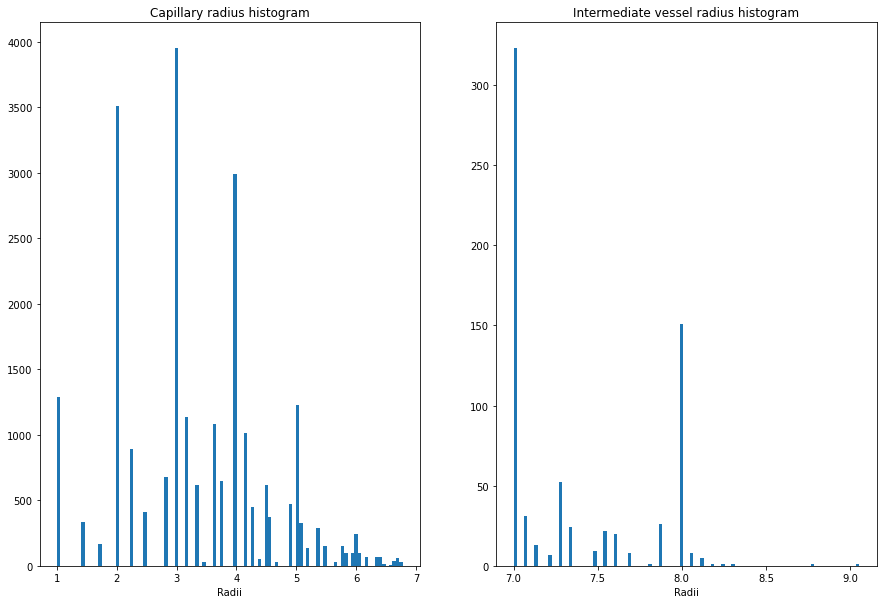

In [61]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.hist(cap_list_direct, 100)
plt.title('Capillary radius histogram')
plt.xlabel("Radii")
plt.subplot(1,2,2)
plt.hist(inter_list_direct, 100)
plt.title('Intermediate vessel radius histogram')
plt.xlabel("Radii")
plt.show()

In [26]:
view(cap)

RuntimeError: C:\P\IPP\ITK-source\ITK\Modules\Core\Common\include\itkImportImageContainer.hxx:192:
Failed to allocate memory for image.

In [23]:
view(inter)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD2; pro…

In [24]:
view(big)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD2; pro…

In [ ]:
diam_cap = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if cap[z,y,x] != 0:
                diam_cap.append([z,y,x])
diam_inter = []
for y in range(height):
    for x in range(width):
        for z in range(slices):        
            if inter[z,y,x] != 0:
                diam_inter.append([z,y,x])
diam_big = []
for y in range(height):
    for x in range(width):
        for z in range(slices):        
            if big[z,y,x] != 0:
                diam_big.append([z,y,x])

#print(diam_only)
#print(diam[14,3,11])
print(len(diam_cap), len(diam_inter), len(diam_big))

In [26]:
#Estimer la localisation de la carie en un point

import math

carie_x = 894
carie_y = 130
carie_z = 213 

dist_cap=[None]*len(diam_cap)
diameters_cap=[None]*len(diam_cap)

for k in range(len(diam_cap)):
    dist_cap[k]= math.sqrt((diam_cap[k][0] - carie_z)**2+(diam_cap[k][1] - carie_y)**2+(diam_cap[k][2] - carie_x)**2)
    diameters_cap[k] = diam[diam_cap[k][0], diam_cap[k][1], diam_cap[k][2]]
#print(dist, diameters)

dist_inter=[None]*len(diam_inter)
diameters_inter=[None]*len(diam_inter)

for k in range(len(diam_inter)):
    dist_inter[k]= math.sqrt((diam_inter[k][0] - carie_y)**2+(diam_inter[k][1] - carie_x)**2+(diam_cap[k][2] - carie_x)**2)
    diameters_inter[k] = diam[diam_inter[k][0], diam_inter[k][1], diam_cap[k][2]]
    
dist_big=[None]*len(diam_big)
diameters_big=[None]*len(diam_big)

for k in range(len(diam_big)):
    dist_big[k]= math.sqrt((diam_big[k][0] - carie_y)**2+(diam_big[k][1] - carie_x)**2+(diam_cap[k][2] - carie_x)**2)
    diameters_big[k] = diam[diam_big[k][0], diam_big[k][1], diam_cap[k][2]]
    #print(dist_big)

In [37]:
array_plot_cap = []
#print(array_plot)
# for k in range(len(dist_cap)):
for k in range(len(dist_cap)):
    array_plot_cap.append([dist_cap[k],diameters_cap[k]])
#     array_plot[k][0] = dist_cap[k]
#     print(k, dist_cap[k], array_plot[k][0])
#     array_plot[k][1] = diameters_cap[k]
#     print(k, diameters_cap[k], array_plot[k][1])
#print(array_plot_cap, len(array_plot_cap), max(array_plot_cap), min(array_plot_cap)) 
array_plot_cap.sort()
#print("Sorted:",array_plot_cap)

array_plot_inter = []
for k in range(len(dist_inter)):
    array_plot_inter.append([dist_inter[k],diameters_inter[k]])
print(array_plot_inter, len(array_plot_inter), max(array_plot_inter), min(array_plot_inter)) 
array_plot_inter.sort()
print("Inter sorted:",array_plot_inter)

array_plot_big = []
for k in range(len(dist_big)):
    array_plot_big.append([dist_big[k],diameters_big[k]])
print(array_plot_big, len(array_plot_big), max(array_plot_big), min(array_plot_big)) 
array_plot_big.sort()
print("Big sorted:",array_plot_big)

NameError: name 'dist_cap' is not defined

In [28]:
dist_cap_sorted = []
diam_cap_sorted = []

for k in range(len(array_plot_cap)):
    dist_cap_sorted.append(array_plot_cap[k][0])
    diam_cap_sorted.append(array_plot_cap[k][1])
print("dist", dist_cap_sorted, "diam", diam_cap_sorted, "longueur dist", len(dist_cap_sorted), "longueur diam", len(diam_cap_sorted))

dist_inter_sorted = []
diam_inter_sorted = []

for k in range(len(array_plot_inter)):
    dist_inter_sorted.append(array_plot_inter[k][0])
    diam_inter_sorted.append(array_plot_inter[k][1])
print("dist", dist_inter_sorted, "diam", diam_inter_sorted)

dist_big_sorted = []
diam_big_sorted = []

for k in range(len(array_plot_big)):
    dist_big_sorted.append(array_plot_big[k][0])
    diam_big_sorted.append(array_plot_big[k][1])
print("dist", dist_big_sorted, "diam", diam_big_sorted)

dist [51.62363799656123, 51.78802950489621, 51.97114584074513, 52.172789842982326, 52.392747589718944, 52.46903848937962, 52.630789467763066, 52.88667128870941, 53.16013544000805, 53.33854141237835, 53.45091205957107, 53.75872022286245, 54.08326913195984, 54.3323108288245, 54.42425929675111, 55.226805085936306, 55.71355310873648, 56.08029957123981, 56.22277118748239, 56.462376853972415, 56.859475903318, 57.21887800367987, 57.271284253105414, 57.697486947006624, 58.137767414994535, 58.137767414994535, 58.59180830116101, 59.033888572581766, 59.0592922409336, 59.135437767890075, 59.20304046246274, 59.405386961116584, 59.53990258641679, 60.03332407921454, 60.07495318350236, 60.21627686929839, 60.4648658313239, 60.74537019394976, 61.05735008989499, 61.07372593840988, 61.40032573203501, 62.03224967708329, 62.76941930590086, 63.0317380372777, 64.00781202322104, 64.1404708432983, 65.0, 65.0, 65.86349520030045, 66.007575322837, 66.73080248281148, 66.85057965343307, 67.00746227100382, 67.6017751

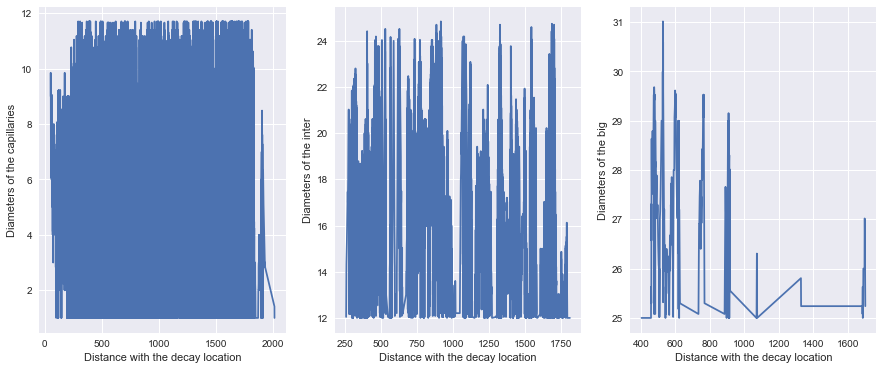

In [30]:
plt.style.use('seaborn')
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
# plt.plot(dist_cap_sorted, diam_cap_sorted, color = 'black',linestyle = 'dashed')
plt.plot(dist_cap_sorted, diam_cap_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Diameters of the capillaries")
plt.subplot(1,3,2)
plt.plot(dist_inter_sorted, diam_inter_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Diameters of the inter")
plt.subplot(1,3,3)
plt.plot(dist_big_sorted, diam_big_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Diameters of the big")
plt.show()

In [1]:
np_view_diam = itk.array_view_from_image(diam_itk)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(diam_255)
plt.subplot(1,2,2)
plt.imshow(np_view_skeleton)
plt.show()

NameError: name 'view' is not defined